In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from keras.layers import LSTM, Dense,Input,Layer
from keras import backend as K,Model
from numpy.random import seed
from imblearn.under_sampling import RandomUnderSampler 
seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [2]:
data = pd.read_excel('brazilian credit card.xlsx')
selected_vars =['cep_cat numeric',
 'score_cat numeric',
 'velocidade_cat numeric',
 'bandeira_cat numeric',
 'qtde_parc_cat numeric',
 'valor_trans_cat numeric',
 'trans_nacional_cat numeric',
 'mcc_cat numeric',
 'valor_trans_ant_cat numeric',
 'mcc_ant_cat numeric',
 'dif_score_cat numeric',
 'cep_ant_cat numeric',
 'lim_cred_cat numeric',
 'Class']

In [3]:
tr_data = data[selected_vars]
tr_data.shape

(374823, 14)

In [4]:
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']

In [5]:
y=tr_data['Class']

In [6]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
X=pd.DataFrame(StandardScaler().fit_transform(X))

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, shuffle=False,random_state=0)
from sklearn.linear_model import SGDOneClassSVM
df1_normal=X_train[y_train==0]
clf = SGDOneClassSVM(nu=0.013,random_state=0)
res = clf.fit_predict(df1_normal)
res[res==1] = 0
res[res==-1] = 1
ros = RandomUnderSampler(sampling_strategy=0.95)
ros.fit_resample(df1_normal,res)
index=ros.sample_indices_
X_train.drop(X_train.index[index], inplace=True)
y_train.drop(y_train.index[index], inplace=True)


In [8]:
X_train.shape

(261913, 13)

In [9]:
X_test.shape

(112447, 13)

In [10]:
# X_train et X_test sont des dataframe qui contient les features
train_LSTM_X=X_train.to_numpy()
test_LSTM_X=X_test.to_numpy()

## Reshape input to be 3D [samples, timesteps, features] (format requis par LSTM)
train_LSTM_X = train_LSTM_X.reshape((train_LSTM_X.shape[0], 1, train_LSTM_X.shape[1]))
test_LSTM_X = test_LSTM_X.reshape((test_LSTM_X.shape[0], 1, test_LSTM_X.shape[1]))

## Recuperation des labels
train_LSTM_y=y_train
test_LSTM_y=y_test

In [11]:
inputs=Input((1,13))
x1=LSTM(50)(inputs)
outputs=Dense(1,activation='sigmoid')(x1)
model=Model(inputs,outputs)

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['Precision','Recall'])

In [13]:
history=model.fit(train_LSTM_X, train_LSTM_y,epochs=500,batch_size=500)

Epoch 1/500
524/524 [==============================] - 5s 4ms/step - loss: 0.2224 - precision: 0.1697 - recall: 0.0922
Epoch 2/500
524/524 [==============================] - 2s 4ms/step - loss: 0.1152 - precision: 0.5685 - recall: 0.0932
Epoch 3/500
524/524 [==============================] - 2s 4ms/step - loss: 0.1112 - precision: 0.5825 - recall: 0.0972
Epoch 4/500
524/524 [==============================] - 2s 4ms/step - loss: 0.1083 - precision: 0.5990 - recall: 0.1073
Epoch 5/500
524/524 [==============================] - 2s 4ms/step - loss: 0.1060 - precision: 0.6216 - recall: 0.1319
Epoch 6/500
524/524 [==============================] - 2s 4ms/step - loss: 0.1040 - precision: 0.6327 - recall: 0.1565
Epoch 7/500
524/524 [==============================] - 2s 4ms/step - loss: 0.1024 - precision: 0.6429 - recall: 0.1692
Epoch 8/500
524/524 [==============================] - 2s 4ms/step - loss: 0.1009 - precision: 0.6557 - recall: 0.1868
Epoch 9/500
524/524 [===========================

In [14]:
# predict probabilities for test set
yhat_probs = model.predict(test_LSTM_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]> 0.5

In [15]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_LSTM_y, yhat_probs)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_LSTM_y, yhat_probs)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_LSTM_y, yhat_probs)
print('Recall: %f' % recall)
f1 = f1_score(test_LSTM_y, yhat_probs)
print('f1: %f' % f1)

Accuracy: 0.999289
Precision: 0.996848
Recall: 0.983967
f1: 0.990366


In [16]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [17]:
cm = confusion_matrix(y_true=test_LSTM_y, y_pred=yhat_probs)

In [18]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = ['Normal','Fraud']

Confusion matrix, without normalization
[[108255     13]
 [    67   4112]]


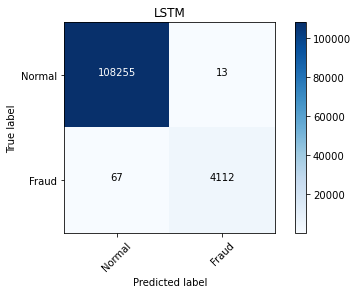

In [19]:
plot_confusion_matrix(cm=cm, classes=labels, title='LSTM')